# Capstone Project 

## Predict Sparkify User Churn  

In this notebook we will analyse and use a small subset (128MB) of the full dataset available (12GB) for this project. The analysis part is done to get familiar with the data and to make decisions on what features to use for predicting churn. In the first part of the notebook standard analysis is performed, the second part is where additional features are created, the third and last part contains the machine learning model creation, opptimazation and evaluation.  

In [1]:
! pip install pyspark

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.sql.functions import sum as Fsum, mean
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, StructType, StructField, StringType, LongType, DateType, DoubleType

from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import datetime
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Data Frames practice") \
    .getOrCreate()

# Load and clean the data

Lets start by importing the data and having a look at it. 
We will start by looking at what column there are, their types e.i. categorcal or numerical, and how many values are missing or are empty. 

In [4]:
# load the data 
data_original = spark.read.json('mini_sparkify_event_data.json')

In [5]:
data_original.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Check number of null values 
Dict_Null = {col:data_original.filter(data_original[col].isNull()).count() for col in data_original.columns}
Dict_Null

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

In [7]:
# check number of empty strings 
Dict_empty = {column:data_original.filter(col(column) == '').count() for column in data_original.columns}
Dict_empty

{'artist': 0,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 0,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 0,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 8346}

In [8]:
# It looks like the missing Ids are for not yet logged in or unregistered users, lets check:
data_original.filter(col('userID') == '').select('page').distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [9]:
# check number of distinct values in every column
Dict_distinct = {column:data_original.select(col(column)).distinct().count() for column in data_original.columns}
Dict_distinct

{'artist': 17656,
 'auth': 4,
 'firstName': 190,
 'gender': 3,
 'itemInSession': 1322,
 'lastName': 174,
 'length': 14866,
 'level': 2,
 'location': 115,
 'method': 2,
 'page': 22,
 'registration': 226,
 'sessionId': 2354,
 'song': 58481,
 'status': 3,
 'ts': 277447,
 'userAgent': 57,
 'userId': 226}

In [10]:
# check number of data point in original dataset
count_original = data_original.count()
count_original

286500

In [11]:
# Have a look at the first line of the dataset
data_original.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [12]:
# looks like there are quite a lot of missing artists in the data
data_original.groupby('artist').count().sort(col('count').desc()).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|58392|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



It looks like there are few missing values in the most important columns i.e. userId and sessionId. The missing values mean that the person who visited the page was not a registerd customer or did not login at the time. Considering the aim of this project, it does not make sense to keep those logs in the data, lets get rid of them. Let's also add a column for when a 'churn' happens. Here churn is defined as either getting to the 'Cancellation Confirmation' or 'Submit Downgrade' pages. 
Another thing we can do already is get rid of the ts (timestamp) column, its not intuative and it would be easier to manipulate the data if we unix timeformat instead. 
Finally, let's only keep columns we can be interested as they could enfluence a user to churn or stay. 

In [13]:
def clean_and_complete_data(data = data_original):
    '''
    input: RDD dataset

    output: dataset with added churn and date columns

    Drops rows where userId = '' as those users are not logged into the service
    as well as adds a churn column where the user visits the pages 'Cancellation confirmation'
    or 'submit Downgrade' 
    '''
    check_churn = udf(lambda ischurn: int((ischurn == 'Cancellation Confirmation') | \
                  (ischurn == 'Submit Downgrade')), IntegerType())
    data = data.filter(col('userId') != '') \
           .withColumn('churn', check_churn(col('page'))) \
           .withColumn('ts', data.ts/1000.0) \
           .withColumn('date', from_unixtime("ts", "yyyy-MM-dd HH:mm:ss")) \
           .withColumn("date", col("date").cast("timestamp"))
    
    
    data = data.select('churn', 'date', 'status', 'userId', 'page', 'level', 'gender', 'sessionId', 'artist')
    return data

In [14]:
# clean data and add churn and date column
data = clean_and_complete_data()
print('Number of rows that were dropped: {}'.format(count_original - data.count()))

Number of rows that were dropped: 8346


In [15]:

data.groupBy('page').count().sort('count').show(20,False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancellation Confirmation|52    |
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Submit Upgrade           |159   |
|Error                    |252   |
|Save Settings            |310   |
|About                    |495   |
|Upgrade                  |499   |
|Help                     |1454  |
|Settings                 |1514  |
|Downgrade                |2055  |
|Thumbs Down              |2546  |
|Logout                   |3226  |
|Roll Advert              |3933  |
|Add Friend               |4277  |
|Add to Playlist          |6526  |
|Home                     |10082 |
|Thumbs Up                |12551 |
|NextSong                 |228108|
+-------------------------+------+



# Exploratory Data Analysis

In the following part we will explore the dataset in detail. To make describing the data easier, the columns are grouped based on type. The catergorical data is plotted and while the describe() function in pyspark is used on the numerical data.  

In [16]:
# Describe categorical data
# show most common and least common
categorical_columns = ['userId', 'page', 'level', 'gender']
min_max_dict = {column: data.groupBy(column).count()\
                .agg(min('count').alias('min'), max('count').alias('max')).collect()[0]\
                for column in categorical_columns}

print(pd.DataFrame(min_max_dict, index = ['min occurences of same value', \
                                          'max occurences of same value']).transpose())

        min occurences of same value  max occurences of same value
userId                             6                          9632
page                              52                        228108
level                          55721                        222433
gender                        123576                        154578


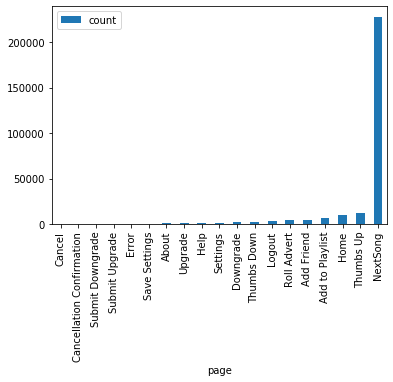

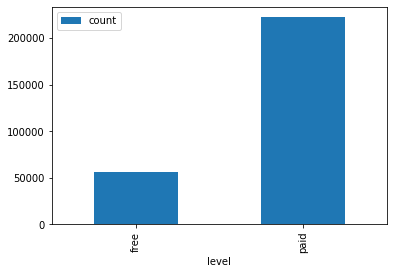

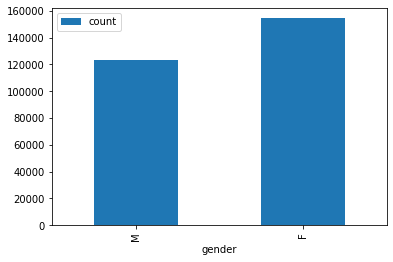

In [17]:
# plot distribution of values count over each distinct value in columns with less than 30 distinct values

for column in categorical_columns: 
    if data.select(column).distinct().count() < 30: 
        count_df = data.groupBy(col(column)).count().sort('count').toPandas()
        count_df.plot.bar(x = column, y = 'count')

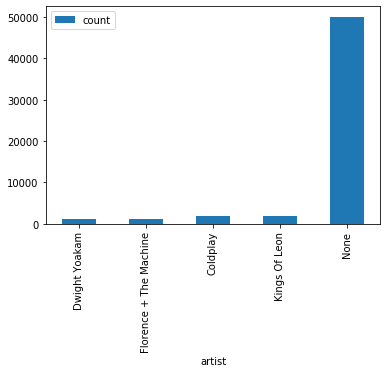

In [18]:
# Lets plot the 5 most common artists only the many and long different artist names will cause pandas to crash
artist_count = data.groupBy(col('artist')).count().sort('count').toPandas().iloc[-5:]
artist_count.plot.bar(x = 'artist', y = 'count')

# Exploratory Churn Data Analysis

The following exploratory data analysis will help us understand the behavior for users who stayed vs users who churned. First lets start by seeing how many churned vs stayed. 

In [19]:
# check total number of userIds in database
all_userIds = data.select('userId').distinct()
print('Number of unique users in dataset: {}'.format(all_userIds.count()))

# get churned userIds 
churned_userIds = data.filter('churn == 1').select('userId').distinct()
number_churned_users = churned_userIds.count()
print('Number of users that churned: {}'.format(number_churned_users))

# create stayed users dataframe
stayed_usersIds = data.select('userId').distinct().subtract(churned_userIds)
number_stayed_users = stayed_usersIds.count()
print('Number of users that stayed: {}'.format(number_stayed_users))

Number of unique users in dataset: 225
Number of users that churned: 92
Number of users that stayed: 133


## Now lets see how the two different groups differ. lets start by creating two different datasets.

In [20]:
# create churned and stayed datasets 
churned_users = churned_userIds.join(data,['userId'], how = 'left')
stayed_users = stayed_usersIds.join(data,['userId'], how = 'left')

In [21]:
# define function to create dataframe with userId, sessionId, churn and session duration. 
def get_churn_user_session_duration_df(data):
    user_session_duration_df = data.groupby('userId', 'sessionId', 'churn')\
    .agg(min(col('date')).alias('sessionStart'), max(col('date')).alias('sessionEnd'))\
    .withColumn('duration in hours', (col('sessionEnd').cast('long')- col('sessionStart').cast('double'))/360)
    
    return user_session_duration_df

# define function to create churn session order dataframe where the user's
# first session will have number 0, second session nr 1, etc.
def get_churn_session_number_df(): 
    user_session_duration_df = get_churn_user_session_duration_df(data)
    time_df = user_session_duration_df.withColumn('sessionId', user_session_duration_df.sessionId.cast('double'))
    window = Window.partitionBy('userId').orderBy(col('sessionStart'))
    churn_session = time_df.withColumn('session_nr', row_number().over(window))

    return churn_session


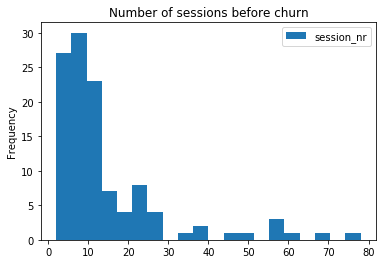

In [22]:
# get session number datafreame for churned users
churn_session = get_churn_session_number_df()

# plot to see after how many sessions the users usually churn 
churns = churn_session.filter(churn_session.churn == '1').select('session_nr')
churns.toPandas().plot.hist(bins = 20, title = 'Number of sessions before churn')

In [23]:
# describe number of sessions before churn 
churns.describe().show()

+-------+------------------+
|summary|        session_nr|
+-------+------------------+
|  count|               114|
|   mean|14.236842105263158|
| stddev| 14.63194627813925|
|    min|                 2|
|    max|                78|
+-------+------------------+



In [24]:
print('25% of the users will churn after {} sessions or less.'.format(churns.approxQuantile('session_nr', [0.25], 0.05)))
print('50% of the users will churn after {} sessions or less.'.format(churns.approxQuantile('session_nr', [0.5], 0.05)))
print('75% of the users will churn after {} sessions or less.'.format(churns.approxQuantile('session_nr', [0.75], 0.05)))


25% of the users will churn after [5.0] sessions or less.
50% of the users will churn after [9.0] sessions or less.
75% of the users will churn after [14.0] sessions or less.


## Lets see if the average session duration as well as total subscription duration differes between the two groups

In [26]:
def get_user_session_duration_df(data):
    '''
    input: RDD dataframe 

    output: subsciption duration dataframe 

    description: 
    Calculates how long a user has been using the service in
    hours
    and adds churn column.
    '''
    time_df = data.groupby('userId', 'sessionId', 'churn')\
    .agg(min(col('date')).alias('sessionStart'), max(col('date')).alias('sessionEnd'))\
    .withColumn('duration in hours', (col('sessionEnd').cast('long')- col('sessionStart').cast('double'))/360)
    return time_df


In [27]:
# calculated the difference between the two user datasets when normalalized by subscription duration

# create dataframe with the subscription duration of each churned user
churn_user_session_duration_df = get_user_session_duration_df(churned_users)
stayed_user_session_duration_df = get_user_session_duration_df(stayed_users)

# sum up all session durations to get total subscription length
churn_user_subscription_length_df = churn_user_session_duration_df.groupBy('userId')\
                                .agg(mean('duration in hours').alias('average_duration'),
                                     Fsum('duration in hours').alias('total_duration'))\
                                .sort('total_duration').toPandas()

stayed_user_subscription_length_df = stayed_user_session_duration_df.groupBy('userId')\
                                .agg(mean('duration in hours').alias('average_duration'),
                                     Fsum('duration in hours').alias('total_duration'))\
                                .sort('total_duration').toPandas()

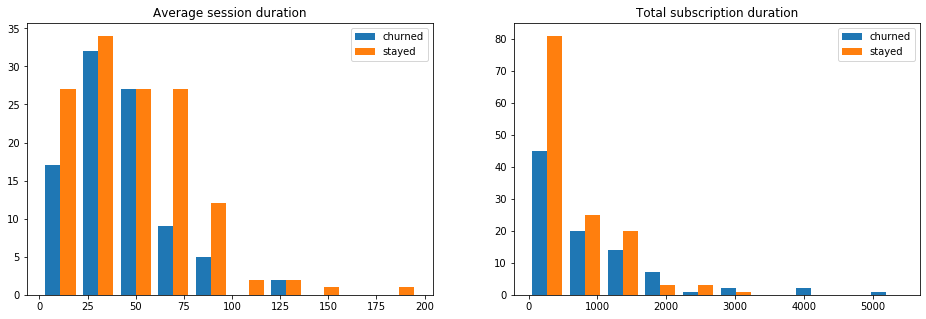

In [28]:
average_duration = [churn_user_subscription_length_df['average_duration'], stayed_user_subscription_length_df['average_duration']]
total_duration = [churn_user_subscription_length_df['total_duration'], stayed_user_subscription_length_df['total_duration']]

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


ax1.hist(average_duration, 10, histtype= 'bar', label = ['churned', 'stayed'])
ax1.title.set_text('Average session duration')
ax1.legend(['churned', 'stayed'])


ax2.hist(total_duration, 10, histtype= 'bar', label = ['churned', 'stayed'])
ax2.title.set_text('Total subscription duration')
ax2.legend(['churned', 'stayed'])

## Lastly lets explore the differences between the two user groups when it comes to visited pages  

In [29]:
# create pandas dataframe of churned and users page counts for easier plotting and devide 
# by number of users in each group

churned_users_page_count = churned_users.groupBy('page').count().toPandas()
churned_users_page_count['count'] = churned_users_page_count['count'] /number_churned_users

stayed_users_page_count = stayed_users.groupBy('page').count().toPandas()
stayed_users_page_count['count'] = stayed_users_page_count['count']/ number_stayed_users

# drop 'NextSong' as it is always the most commonly visited page for both groups of users 
churned_users_page_count = churned_users_page_count[churned_users_page_count['page'] != 'NextSong']
stayed_users_page_count = stayed_users_page_count[stayed_users_page_count['page'] != 'NextSong']

# rename columns 
churned_users_page_count = churned_users_page_count.rename(columns = {'count' : 'churned'})
stayed_users_page_count = stayed_users_page_count.rename(columns = {'count' : 'stayed'}) 

In [30]:
# merge the two dataframes and calculate the difference between them 
users_page_count = stayed_users_page_count.merge(churned_users_page_count, how = 'outer', on ='page').fillna(0)
users_page_count['diff'] = users_page_count['stayed'] - users_page_count['churned']
users_page_count = users_page_count.sort_values(by = 'diff')
users_page_count

,page,stayed,churned,diff
10,Thumbs Up,47.045113,68.413043,-21.367931
1,Home,37.285714,55.684783,-18.399068
3,Roll Advert,11.857143,25.608696,-13.751553
8,Add to Playlist,24.285714,35.826087,-11.540373
9,Add Friend,16.255639,22.989130,-6.733491
0,Thumbs Down,8.609023,15.228261,-6.619238
4,Logout,11.744361,18.086957,-6.342596
2,Downgrade,7.443609,11.576087,-4.132478
11,Help,5.383459,8.021739,-2.638280
7,Settings,5.744361,8.152174,-2.407813


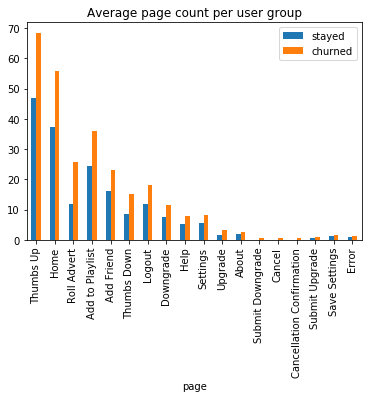

In [31]:
users_page_count.plot.bar(x = 'page', y= ['stayed', 'churned'], title = 'Average page count per user group')

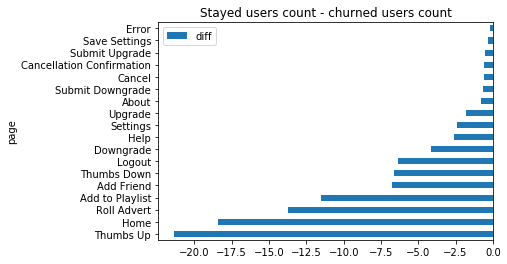

In [32]:
users_page_count.plot.barh(x = 'page', y= ['diff'], title = 'Stayed users count - churned users count')

# Check number of missing artist for each group

In [38]:
print('missing artists searches/ total churned users: {}'\
      .format(churned_users.filter(col('artist').isNull()).count()/number_churned_users))

missing artists searches/ total churned users: 281.19565217391306


In [39]:
print('missing artists searches/ total stayed users: {}'\
      .format(stayed_users.filter(col('artist').isNull()).count()/number_stayed_users))

missing artists searches/ total stayed users: 181.77443609022558


In [36]:
data.filter(col('artist').isNull()).groupby('userId').count()\
.withColumnRenamed('count', 'missing_artist').show()

+------+--------------+
|userId|missing_artist|
+------+--------------+
|100010|           106|
|200002|            87|
|   125|             3|
|    51|           353|
|   124|           746|
|     7|            51|
|    54|           596|
|    15|           364|
|   155|           182|
|   132|           376|
|   154|            34|
|100014|            53|
|   101|           352|
|    11|           201|
|   138|           399|
|300017|           796|
|    29|           575|
|    69|           217|
|100021|            89|
|    42|           684|
+------+--------------+
only showing top 20 rows



## Extract feature data and create machine learning model input 

Now that we are done with the analysis, we can clearly see a correlation between the pages a user uses and the churn rate.

In [40]:

def get_agg_page_df(data): 
    '''
    input: RDD dataset

    output: user-page interaction count dataframe 

    description: 
    Calculates the number of times each user interacts with each page 
    and outputs a dataframe with the most interesting pages as columns, 
    userId as index and and count as values. 
    intersting_pages = ['userId', 'Error', 'Help', 'Home', 
                        'Logout', 'NextSong', 'Roll Advert',
                        'Thumbs Down', 'Thumbs Up', 'Add to Playlist']
    
    '''
    # Create a dataframe with the count of each page during each session
    page_df = data.groupby('userId', 'page').agg({'page' : 'count'})\
        .withColumnRenamed('count(page)', 'page_count')

    # unstack the page column 
    page_df = page_df.groupBy('userId').pivot('page').max('page_count').fillna(0)
    
    # keep interesting pages only 
    intersting_pages = ['userId', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert',
                         'Thumbs Down', 'Thumbs Up', 'Add to Playlist']
    page_df = page_df.select(intersting_pages)
    return page_df 

def add_columns_per_duration(dataframe, data=data ):
    '''
    input: feature dataframe 

    output: column / subscription duration

    description: 
    Calculates how long a user has been using the service and
    calculated the interaction frequency for each column and user
    per subscription duration. 
    '''
    for page in dataframe.columns[1:]:
        column_name = page + '/duration'
        dataframe = dataframe.withColumn(column_name, (col(page)/col('duration in hours')).cast('double'))
    
    return dataframe

def add_user_subscription_duration_and_churn(dataframe, data):
    '''
    input: RDD dataframe 

    output: subsciption duration dataframe 

    description: 
    Calculates how long a user has been using the service in
    hours
    and adds churn column.
    '''
    time_df = data.groupby('userId', 'sessionId', 'churn')\
    .agg(min(col('date')).alias('sessionStart'), max(col('date')).alias('sessionEnd'))\
    .withColumn('duration in hours', (col('sessionEnd').cast('long')- col('sessionStart').cast('double'))/360)
    
    duration_agg_df = time_df.groupBy('userId').agg(Fsum('duration in hours').alias('duration in hours'), 
                                               max('churn').alias('churn'))
    
    dataframe = dataframe.join(duration_agg_df, on = ['userId'], how = 'inner')
    
    return dataframe


# every entry has a page value nr_entries = nr_pages visited
def add_column_for_total_entry_count(dataframe, data = data):
    total_entries = data.groupBy('userId').count().withColumnRenamed('count', 'activity')
    dataframe = dataframe.join(total_entries, on = ['userId'], how = 'inner')
    return dataframe

def add_session_number_column(dataframe, data = data):
    total_sessions = data.groupBy('userId').agg(count('sessionId').alias('nr_sessions'))
    dataframe = dataframe.join(total_sessions, on = ['userId'], how = 'inner')
    return dataframe

def add_column_for_total_missing_artist(dataframe, data = data):
    missing_artists_count = data.filter(col('artist').isNull()).groupby('userId').count()\
            .withColumnRenamed('count', 'missing_artist')
    dataframe = dataframe.join(missing_artists_count, on = ['userId'], how = 'outer').fillna(0)
    return dataframe
    
def get_feature_df(data): 
    '''
    input: dataframe  

    output: complete feature dataframe

    description: 
    Creates dataframe with relevent features for a machine learning 
    classification usage. 
    '''
    page_feature = get_agg_page_df(data)
    feature_df = add_user_subscription_duration_and_churn(page_feature, data)
    feature_df = add_session_number_column(feature_df, data)
    feature_df = add_column_for_total_missing_artist(feature_df, data)
    feature_df = add_column_for_total_entry_count(feature_df, data)
    feature_df = add_columns_per_duration(feature_df, data=data )
    return feature_df.drop('sessionId') 

feature_df = get_feature_df(data)

In [41]:
# drop userId as it is not a relevent feature. 
feature_df = feature_df.drop('userId')

In [42]:
# final dataset columns 
feature_df.columns

['Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Thumbs Down',
 'Thumbs Up',
 'Add to Playlist',
 'duration in hours',
 'churn',
 'nr_sessions',
 'missing_artist',
 'activity',
 'Error/duration',
 'Help/duration',
 'Home/duration',
 'Logout/duration',
 'NextSong/duration',
 'Roll Advert/duration',
 'Thumbs Down/duration',
 'Thumbs Up/duration',
 'Add to Playlist/duration',
 'duration in hours/duration',
 'churn/duration',
 'nr_sessions/duration',
 'missing_artist/duration',
 'activity/duration']

# Predicting Churn with Machine Learning 
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [43]:
# rescale columns
def prepare_feature_df_for_ML(feature_df = feature_df):
    label_column = 'label'
    feature_df = feature_df.withColumnRenamed('churn', 'label')
    feature_columns = feature_df.columns
    feature_columns.remove(label_column)

    # define assembler to get feature vector
    assembler = VectorAssembler(inputCols=feature_columns, outputCol='features_vector')

    # define scaler 
    scaler = MinMaxScaler(inputCol= 'features_vector', outputCol=('features'))
    
    # define and fit pipeline
    pipeline = Pipeline(stages = [assembler, scaler])
    scalerModel = pipeline.fit(feature_df)
    
    # transorm data
    scaledData = scalerModel.transform(feature_df)
    
    # create final dataset
    final_data = scaledData.select('features', 'label')
    return final_data

final_feature_df = prepare_feature_df_for_ML()


In [44]:
# split data into test and train 
train, test = final_feature_df.randomSplit([0.75, 0.25])
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   72|
|    0|  105|
+-----+-----+



In [45]:
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   20|
|    0|   28|
+-----+-----+



### Instead of repeating code, lets define some helper functions 

In [46]:
def setup_model(paramGrid, model):
    # leaving the test data to be used for validation
    tvs = CrossValidator(estimator=model,
                         estimatorParamMaps=paramGrid,
                         evaluator = BinaryClassificationEvaluator(),
                         numFolds = 3)
    return tvs
    
def model_train_predict(model, train = train, test = test):
    model = model.fit(train)
    predictions = model.transform(test).select("label", "prediction").toPandas()
    
    return predictions

def print_metrics(predictions):
    
    # Calculate and print f1, recall and precision scores
    y_test = predictions.label
    y_pred =  predictions.prediction
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    model_metrics = {'f1' : f1, 
                    'recall': recall,
                    'precision': precision}
    print('F1-Score: {}, Recall: {}, Precision: {}'.format(f1, recall, precision))
    
    return model_metrics

def plot_confusion_matrix(predictions):
    y_test = predictions.label
    y_pred =  predictions.prediction
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues')

## Logistic regression model 

Lets train a logistic model on the data and see how well it performs by plotting the summary and confusion matrix. 
This model will be optimized by varying two parameters: 
* elasticNetParam: sets the ratio between an L1 and L2 penalty in an elastic net regularization  
* regParam: regularization parameter that is applied to the weights of eatch parameter to avoid overfitting

F1-Score: 0.8947368421052632, Recall: 0.85, Precision: 0.9444444444444444


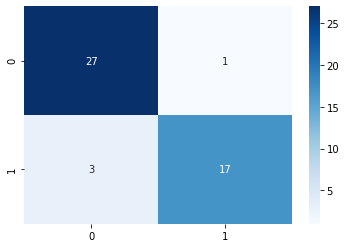

In [47]:
# initiate model
lr_model = LogisticRegression(featuresCol = 'features', labelCol= 'label')

# set up parameter grid suited for a regression classifier
lr_paramGrid = ParamGridBuilder()\
    .addGrid(lr_model.elasticNetParam, [0, 0.5, 1])\
    .addGrid(lr_model.regParam, [0.1, 0.01])\
    .addGrid(lr_model.maxIter, [50, 100, 200])\
    .build()

# setup model
lr_model = setup_model(paramGrid = lr_paramGrid, model = lr_model )

# train model and get predictions for test data set
lr_predictions = model_train_predict(lr_model)

# evaluate model 
print_metrics(lr_predictions)
plot_confusion_matrix(lr_predictions)

## Support Vector Machine 

F1-Score: 0.6, Recall: 0.45, Precision: 0.9


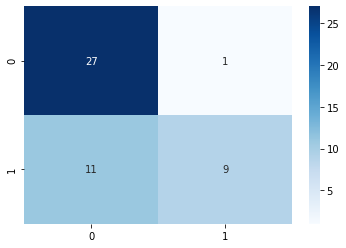

In [49]:
# train test a linear support vector machine classifier 
svm_model = LinearSVC(featuresCol = 'features', labelCol= 'label')

# define parameters that can be optimized
svm_paramGrid = ParamGridBuilder()\
        .addGrid(svm_model.maxIter, [50, 100])\
        .addGrid(svm_model.regParam, [0.1, 1.0])\
        .build()

# setup model
svm_model = setup_model(paramGrid = svm_paramGrid, model = svm_model )

# train model and get predictions for test data set
svm_predictions = model_train_predict(svm_model)

# evaluate model 
print_metrics(svm_predictions)
plot_confusion_matrix(svm_predictions)

# Conclusion 

This projects aims at understanding and predicting churn in a small user dataset by using Apache Spark's analyrics engine and its powerful libraries.
The project goes through the different technical steps of the CRISP DM process starting with data understanding, followed by feature extraction, modeling and finally evaluation. 
 
Using the methods presented in this jupyter-notebook, and the best performing model which is the logistic reression classifier, we are able to correctly identify 85% of unhappy users and offer them discounts or rewards to keep their subscriptions. Furthermore, with the high precision score 94.5% achieved by the model , we are able to save money by avoiding giving out offers to already happy and staying customers.
Future work can include adding a location feature to include the influence of internet connection quality on churn as well as trying out other machine learning models such as Random Forest classifiers.
